In [ ]:
!nvidia-smi

Sun Jul 24 05:29:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow==1.14.0
%tensorflow_version 1.x
!pip install h5py==2.10.0
!pip install keras==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 49 kB/s 
     |████████████████████████████████| 50 kB 9.5 MB/s 
     |████████████████████████████████| 3.1 MB 69.5 MB/s 
     |████████████████████████████████| 488 kB 62.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
ERROR: pip's dependency resolver does not currently ta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
#from keras.engine.topology import Container
from keras.engine.network import Network
from keras.layers import *
from keras import backend
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *
#from tinyec import registry
#from Crypto.Cipher import AES
#import hashlib, secrets, binascii

%matplotlib inline

Using TensorFlow backend.


In [ ]:
def load_dataset_small(num_images_per_class_train=1051):
#     """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

#     Arguments:
#         num_images_per_class_train: number of images per class to load into training dataset.
#         num_images_test: total number of images to load into training dataset.
#     """
     X_train = []
     X_input = []
     cover_ = []
    
##


     # input dataset for ploting
     image1=None
     train_dir = os.path.join('/content/drive/My Drive/chest_xray/train/', 'NORMAL')
     train_imgs = os.listdir(train_dir)
     random.shuffle(train_imgs)
     for img_name_i in train_imgs[0:num_images_per_class_train]:
      
        img_i = image.load_img(os.path.join(train_dir, img_name_i),target_size=(64,64))
        
        x = image.img_to_array(img_i)
       

        X_input.append(x)

    
#    
     image1=None
     train_dir = os.path.join('/content/drive/My Drive/chest_xray/train/', 'NORMAL')
     train_imgs = os.listdir(train_dir)
     random.shuffle(train_imgs)
     for img_name_i in train_imgs[0:num_images_per_class_train]:
      
        img_i = image.load_img(os.path.join(train_dir, img_name_i),target_size=(64,64))
        im2 = image.load_img('/content/drive/My Drive/chest_xray/train/NORMAL/IM-0115-0001.jpeg',target_size=(64,64))

        ###################
        #im1np = np.array(img_i)*255
        #im2np = np.array(im2)*255

        # XOR with Numpy
        result = np.bitwise_xor(img_i, im2).astype(np.uint8)
        ################################
        x = image.img_to_array(result)
       

        X_train.append(x)


      #cover
     cover_dir = os.path.join('/content/drive/My Drive/', 'Cover')
     print(cover_dir)
     cover_imgs = os.listdir(cover_dir)
     random.shuffle(cover_imgs)
     for img_name_i in cover_imgs[0:num_images_per_class_train]:
        img_i_2 = image.load_img(os.path.join(cover_dir, img_name_i),target_size=(64,64))
        x_2 = image.img_to_array(img_i_2)

        cover_.append(x_2)
     

    
#     # Return train and test data as numpy arrays.
#     #return np.array(X_train), np.array(X_test)
     return np.array(X_train), np.array(cover_), np.array(X_input)
# # Load dataset.
# #X_train_orig, X_test_orig = load_dataset_small()
X_train_orig , X_cover_orig, X_input_orig = load_dataset_small()

X_input = X_input_orig/255
X_train = X_train_orig/255
X_cover = X_cover_orig/255



#Print statistics.
print ("Number of input examples = " + str(X_input.shape[0]))
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of Cover examples = " + str(X_cover.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

/content/drive/My Drive/Cover
Number of input examples = 1051
Number of training examples = 1051
Number of Cover examples = 1051
X_train shape: (1051, 64, 64, 3)


In [ ]:
# S1: secret image1
input_sec1 = X_input[0:X_input.shape[0] // 4]
# S2: secret image2
input_sec2 = X_input[X_input.shape[0] // 4 : 2*(X_input.shape[0] // 4)]
# S3: secret image3
input_sec3 = X_input[2*(X_input.shape[0] // 4) : 3*(X_input.shape[0] // 4)]


# C: cover image
input_C = X_cover[3*(X_cover.shape[0] // 4):]

In [ ]:


# ECS1: secret image1
input_S1 = X_train[0:X_train.shape[0] // 4]
# ECS2: secret image2
input_S2 = X_train[X_train.shape[0] // 4 : 2*(X_train.shape[0] // 4)]
# ECS3: secret image3
input_S3 = X_train[2*(X_train.shape[0] // 4) : 3*(X_train.shape[0] // 4)]




# C: cover image
input_C = X_cover[3*(X_cover.shape[0] // 4):]

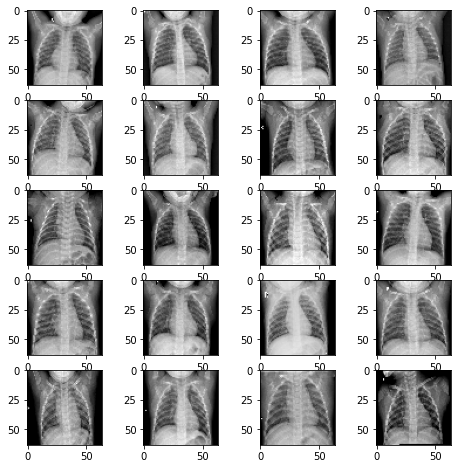

In [ ]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_input.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_input[img_idx])
plt.show()

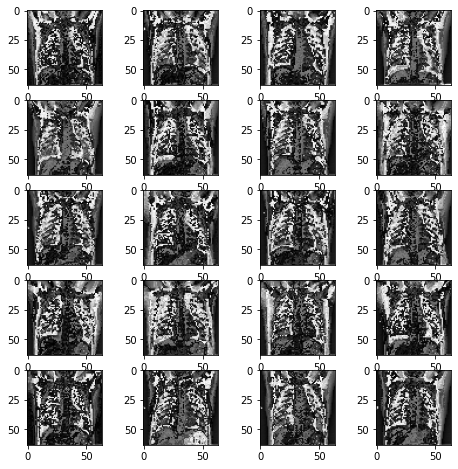

In [ ]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

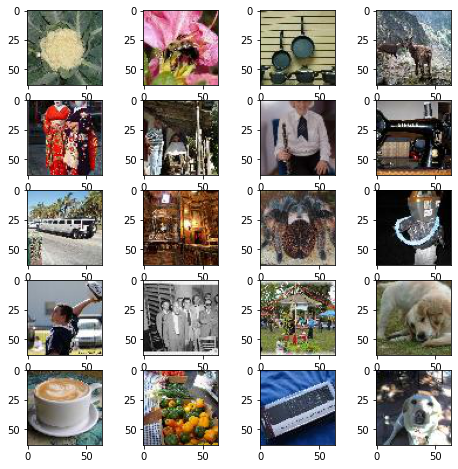

In [ ]:
# Show sample images from the cover dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from cover dataset
    img_idx = np.random.choice(X_cover.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_cover[img_idx])
plt.show()

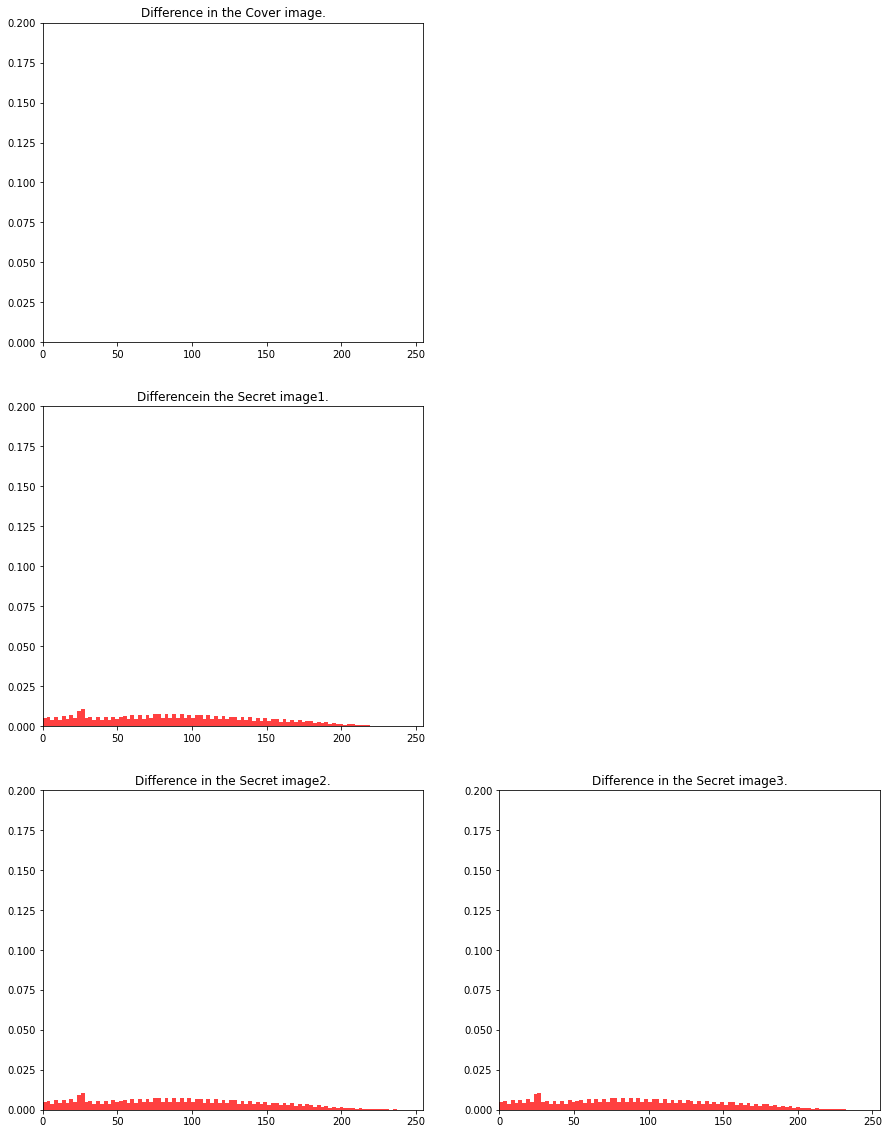

In [ ]:
diff_S1 = np.abs(input_sec1 - input_S1)
diff_S2 = np.abs(input_sec2 - input_S2)
diff_S3 = np.abs(input_sec3- input_S3)
#print(diff_S1, diff_S2, diff_S3)
#input_C=np.expand_dims(input_C, axis=-1)
#decoded_C.resize((263,64,64,3))
#input_C=np.resize(input_C,(262,64,64,3))

#diff_C = np.abs(decoded_C - input_C)

#print(decoded_C.shape,input_C.shape)
# Get absolute difference between the outputs and the expected values.
diff_S1, diff_S2, diff_S3, diff_C = np.abs(input_sec1 - input_S1), np.abs(input_sec2 - input_S2), np.abs(input_sec3 - input_S3), np.abs(input_C - input_C) 

def pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_S1flat = diff_S1.flatten()
    diff_S2flat = diff_S2.flatten()
    diff_S3flat = diff_S3.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 20))
    a=fig.add_subplot(3,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, density = True, alpha=0.75, facecolor='red')
    a.set_title('Difference in the Cover image.')
    plt.axis([0, 255, 0, 0.2])
    
    a=fig.add_subplot(3,2,3)
    imgplot = plt.hist(255* diff_S1flat, 100, density = True, alpha=0.75, facecolor='red')
    a.set_title('Differencein the Secret image1.')
    plt.axis([0, 255, 0, 0.2])

    a=fig.add_subplot(3,2,5)
    imgplot = plt.hist(255* diff_S2flat, 100, density = True, alpha=0.75, facecolor='red')
    a.set_title('Difference in the Secret image2.')
    plt.axis([0, 255, 0, 0.2])

    a=fig.add_subplot(3,2,6)
    imgplot = plt.hist(255* diff_S3flat, 100, density = True, alpha=0.75, facecolor='red')
    a.set_title('Difference in the Secret image3.')
    plt.axis([0, 255, 0, 0.2])
    
    plt.show()
pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C)

In [ ]:
# Variable used to weight the losses of the secret and cover images 
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    #return s_true-s_pred

    print(s_true.shape, s_pred.shape)
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    print(y_true.shape, y_pred.shape)
    s1_true, s2_true, s3_true, c_true = y_true[...,0:3], y_true[...,3:6], y_true[...,6:9], y_true[...,9:12]
    s1_pred, s2_pred, s3_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6], y_pred[...,6:9], y_pred[...,9:12]

    #s_loss = rev_loss(s_true, s_pred)
    s1_loss = beta * K.sum(K.square(s1_true - s1_pred))
    s2_loss = beta * K.sum(K.square(s2_true - s2_pred))
    s3_loss = beta * K.sum(K.square(s3_true - s3_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s1_loss + c_loss + s2_loss + s3_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    input_S3 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Layer
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_1')(input_S1)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_1')(input_S1)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_1')(input_S1)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_1')(x)
    x1 = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_2')(input_S2)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_2')(input_S2)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_2')(input_S2)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_2')(x)
    x2 = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_3')(input_S3)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_3')(input_S3)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_3')(input_S3)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_3')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_3')(x)
    x3_1 = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x1, x2, x3_1])
    
    # Hiding Layer
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S1, input_S2, input_S3, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder1(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise1')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_1')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_1')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_1')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    output_S1prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S1')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S1prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S1prime)
        
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder2(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_2')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_2')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_2')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    output_S2prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S2')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S2prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_S2prime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S2prime)

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder3(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_S3prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S3')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S3prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_S2prime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S3prime)

# Full model.
def make_model(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    input_S3 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
   
    
    decoder1 = make_decoder1(input_size)
    decoder1.compile(optimizer='adam', loss=rev_loss)
    decoder1.trainable = False

    decoder2 = make_decoder2(input_size)
    decoder2.compile(optimizer='adam', loss=rev_loss)
    decoder2.trainable = False

    decoder3 = make_decoder3(input_size)
    decoder3.compile(optimizer='adam', loss=rev_loss)
    decoder3.trainable = False
    import numpy 
    
    output_Cprime = encoder([input_S1, input_S2, input_S3, input_C])
    #print("print:", output_Cprime)

   
    
  

    #####################
    output_S1prime = decoder1(output_Cprime)
    output_S2prime = decoder2(output_Cprime)
    output_S3prime = decoder3(output_Cprime)

    print("output_S1prime", output_S1prime)

    autoencoder1 = Model(inputs=[input_S1, input_S2, input_S3, input_C],
                        outputs=concatenate([output_S1prime, output_S2prime, output_S3prime, output_Cprime]))
    autoencoder1.compile(optimizer='adam', loss=full_loss)
    
    # autoencoder2 = Model(inputs=[input_S1, input_S2, input_C],
    #                     outputs=concatenate([output_S2prime, output_Cprime]))
    # autoencoder2.compile(optimizer='adam', loss=full_loss)


    return encoder, decoder1, decoder2, decoder3, autoencoder1

In [ ]:
!nvidia-smi

Sun Jul 24 05:35:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
encoder_model, reveal_model1, reveal_model2, reveal_model3, autoencoder_model = make_model(input_S1.shape[1:])

#print("encoder", encoder_model, autoencoder_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(?, ?, ?, ?) (?, 64, 64, 3)
(?, ?, ?, ?) (?, 64, 64, 3)
(?, ?, ?, ?) (?, 64, 64, 3)
output_S1prime Tensor("model_1/output_S1/Relu:0", shape=(?, 64, 64, 3), dtype=float32)
(?, ?, ?, ?) (?, 64, 64, 12)


In [ ]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [ ]:
!nvidia-smi

Sun Jul 24 05:36:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
NB_EPOCHS = 750
BATCH_SIZE = 256

m = input_S1.shape[0]
loss_history = []
#loss_history2 = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    #ae_loss2 = []
    rev_loss1 = []
    rev_loss2 = []
    rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_S3, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2, batch_S3, batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3)))
        
        #print(np.concatenate((batch_S1, batch_S2, batch_S3, batch_C),axis=3))
        #ae_loss2.append(autoencoder_model2.train_on_batch(x=[batch_S1, batch_S2, batch_C],
        #                                           y=np.concatenate((batch_S2, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
                                              y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        #K.set_value(autoencoder_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev1 {:10.2f} | Loss Rev2 {:10.2f} | Loss Rev3 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2), np.mean(rev_loss3)))
    
    autoencoder_model.save_weights('/content/drive/My Drive/model_main_encry')
    #autoencoder_model2.save_weights('models/model'+str(epoch))
    
    loss_history.append(np.mean(ae_loss))
    #loss_history2.append(np.mean(ae_loss2))

  0%|          | 0/2 [00:00<?, ?it/s]/tensorflow-1.15.2/python3.7/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
Epoch 1 | Batch: 256 of 262. Loss AE  315977.03 | Loss Rev1   78297.18 | Loss Rev2   96537.02 | Loss Rev3   90017.40: 100%|██████████| 2/2 [00:06<00:00,  3.43s/it]
Epoch 2 | Batch: 256 of 262. Loss AE  873924.81 | Loss Rev1  333282.78 | Loss Rev2  288203.19 | Loss Rev3  109838.80: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it]
Epoch 3 | Batch: 256 of 262. Loss AE 1030414.88 | Loss Rev1  266843.75 | Loss Rev2  164690.62 | Loss Rev3  338374.41: 100%|██████████| 2/2 [00:03<00:00,  1.81s/it]
Epoch 4 | Batch: 256 of 262. Loss AE 6447731.50 | Loss Rev1 4309978.50 | Loss Rev2 1722234.50 | Loss Rev3  327147.34: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]
Epoch 5 | Batch: 256 of 262.

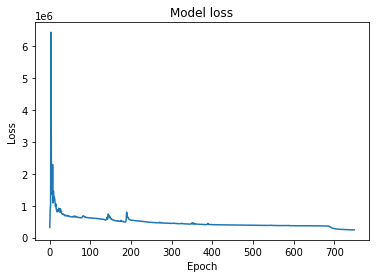

In [ ]:
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
autoencoder_model.load_weights('/content/drive/My Drive/22/model_main_encry')

In [ ]:
decoded = autoencoder_model.predict([input_S1, input_S2, input_S3, input_C])
decoded_S1, decoded_S2, decoded_S3, decoded_C = decoded[...,0:3], decoded[...,3:6], decoded[...,6:9], decoded[...,9:12]
# a = (decoded_S1[0]*.1/255).astype(np.uint8)


# im2 =image.load_img('/content/drive/My Drive/chest_xray/train/NORMAL/IM-0115-0001.jpeg', target_size=(64,64))


# im2np = np.array(im2)*255
# print(type(im2np), type(a))
# def rgb2gray(rgb):
#     return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# result = np.bitwise_xor(a, im2np).astype(np.uint8)
# z = rgb2gray(result)


# #________________________________________________#
# fig=plt.figure(figsize=(8, 8))
# columns = 4
# rows = 5
# for i in range(1, columns*rows +1):
#     # Randomly sample from training dataset
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(z, cmap=plt.get_cmap('gray'))
#     #plt.imsave('/content/drive/My Drive/amin_main.png', decoded_S3[0].astype(np.uint8))
# plt.show()



In [ ]:
decoded = autoencoder_model.predict([input_S1, input_S2, input_S3, input_C])
#decoded_S1, decoded_S2, decoded_S3, decoded_C = decoded[...,0:3], decoded[...,3:6], decoded[...,6:9], decoded[...,9:12]





decoded_S1, decoded_S2, decoded_S3, decoded_C = decoded[...,0:3], decoded[...,3:6], decoded[...,6:9], decoded[...,9:12]

#print(decoded_S1)



diff_S1 = np.abs(decoded_S1 - input_S1)
diff_S2 = np.abs(decoded_S2 - input_S2)
diff_S3 = np.abs(decoded_S3 - input_S3)
#print(diff_S1, diff_S2, diff_S3)
#input_C=np.expand_dims(input_C, axis=-1)
#decoded_C.resize((263,64,64,3))
input_C=np.resize(input_C,(262,64,64,3))

#diff_C = np.abs(decoded_C - input_C)

#print(decoded_C.shape,input_C.shape)
# Get absolute difference between the outputs and the expected values.

diff_S1, diff_S2, diff_S3, diff_C = np.abs(decoded_S1 - input_S1), np.abs(decoded_S2 - input_S2), np.abs(decoded_S3 - input_S3), np.abs(decoded_C - input_C) 


print(diff_C)

[[[[7.89655298e-02 1.89369321e-02 3.45578194e-02]
   [2.59044766e-02 2.82043815e-02 9.70822573e-03]
   [1.69754028e-02 3.64079177e-02 4.51167226e-02]
   ...
   [8.55945796e-02 5.84095418e-02 9.73830819e-02]
   [1.29781887e-01 1.68441236e-02 4.99541759e-02]
   [1.73856005e-01 5.11913002e-02 7.64350295e-02]]

  [[5.38630784e-02 3.16226482e-02 1.52837545e-01]
   [3.37266773e-02 3.49934697e-02 1.99647546e-02]
   [1.06395185e-02 4.45831716e-02 4.39492464e-02]
   ...
   [5.21167070e-02 2.97261775e-02 9.55079794e-02]
   [1.06275782e-01 3.35131288e-02 8.84852409e-02]
   [5.64730614e-02 6.33782148e-03 1.33565068e-01]]

  [[1.24959931e-01 2.70178318e-02 4.45055366e-02]
   [2.93923914e-03 5.05553186e-02 4.72403765e-02]
   [6.00750297e-02 1.89027190e-02 8.62310529e-02]
   ...
   [1.90902948e-02 4.55429852e-02 2.07193494e-02]
   [9.54837501e-02 2.44876742e-02 4.04596925e-02]
   [4.78334129e-02 2.06736326e-02 2.07714438e-02]]

  ...

  [[1.47342741e-01 2.37444639e-02 4.70736027e-02]
   [2.01018512e-

In [ ]:
def pixel_errors(input_S1, input_S2, input_S3, input_C, decoded_S1, decoded_S2, decoded_S3, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_S1pixel = np.sqrt(np.mean(np.square(255*(input_S1 - decoded_S1))))
    see_S2pixel = np.sqrt(np.mean(np.square(255*(input_S2 - decoded_S2))))
    see_S3pixel = np.sqrt(np.mean(np.square(255*(input_S3 - decoded_S3))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_S1pixel, see_S2pixel, see_S3pixel, see_Cpixel

def pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_S1flat = diff_S1.flatten()
    diff_S2flat = diff_S2.flatten()
    diff_S3flat = diff_S3.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 20))
    a=fig.add_subplot(3,2,1)
    print("Distribution of error in the Cover image.--:", 255* diff_Cflat)
        
    imgplot = plt.hist(255* diff_Cflat, 100, density = True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(3,2,3)
    imgplot = plt.hist(255* diff_S1flat, 100, density = True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image1.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(3,2,5)
    imgplot = plt.hist(255* diff_S2flat, 100, density = True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image2.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(3,2,6)
    imgplot = plt.hist(255* diff_S3flat, 100, density = True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image3.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [ ]:
S1_error, S2_error, S3_error, C_error = pixel_errors(input_S1, input_S2, input_S3, input_C, decoded_S1, decoded_S2, decoded_S3, decoded_C)

print ("S1 error per pixel [0, 255]:", S1_error)
print ("S2 error per pixel [0, 255]:", S2_error)
print ("S2 error per pixel [0, 255]:", S3_error)
print ("C error per pixel [0, 255]:", C_error)

S1 error per pixel [0, 255]: 12.95623
S2 error per pixel [0, 255]: 11.663822
S2 error per pixel [0, 255]: 6.984207
C error per pixel [0, 255]: 27.992722


Distribution of error in the Cover image.--: [20.13621    4.8289175  8.812244  ...  8.2468195 13.077758  46.636555 ]


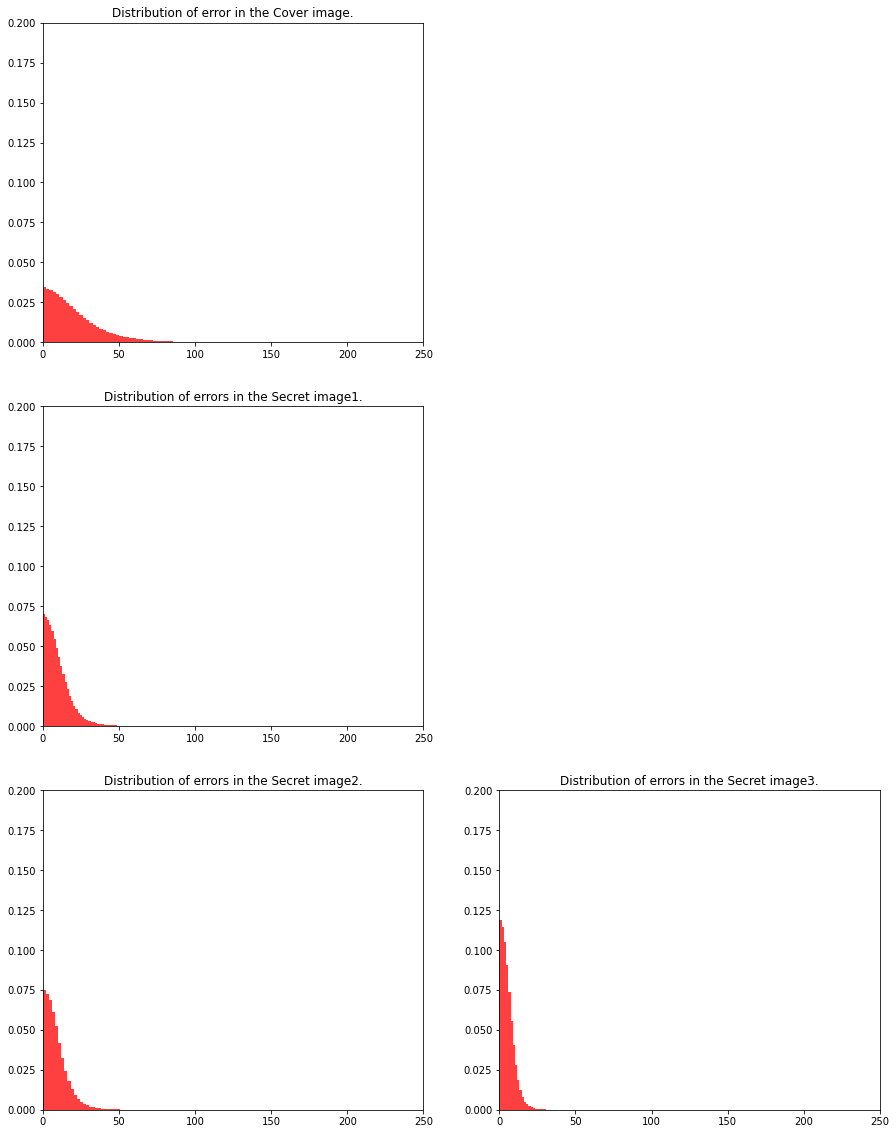

In [ ]:
pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

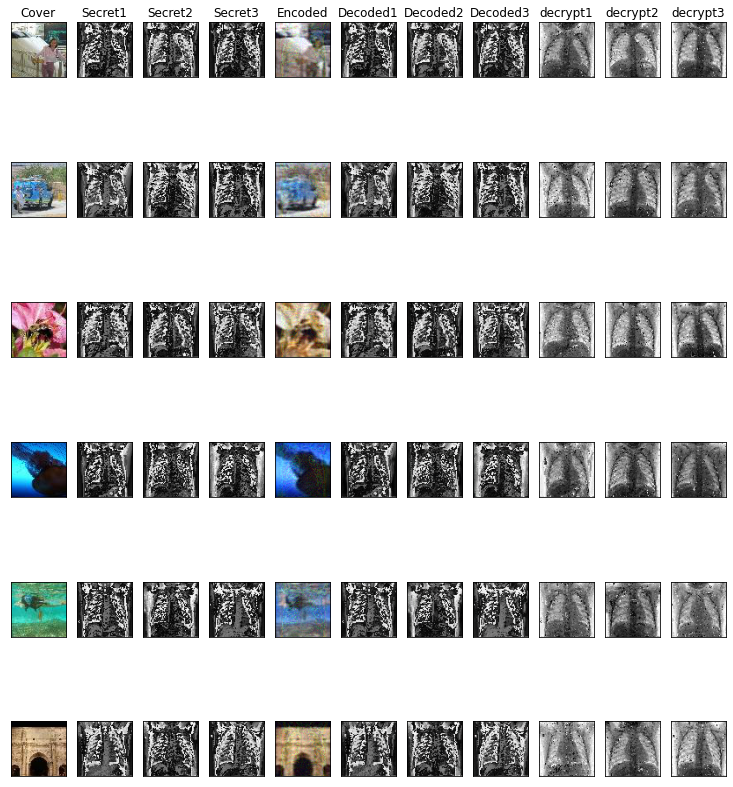

In [ ]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
      plt.imshow(img, cmap = plt.get_cmap('gray'))

        #---------------------#
        # a = (img*.1/255).astype(np.uint8)


        # im2 =image.load_img('/content/drive/My Drive/chest_xray/train/NORMAL/IM-0115-0001.jpeg', target_size=(64,64))


        # im2np = np.array(im2)*255
        # print(type(im2np), type(a))
        

        # result = np.bitwise_xor(a, im2np).astype(np.uint8)
        # z = rgb2gray(result)
        # plt.imshow(z)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)
    

plt.figure(figsize=(14, 15))

rand_indx = [random.randint(0, 200) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 12 if SHOW_DIFF else 8
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S1[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret1')

    show_image(input_S2[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Secret2')

    show_image(input_S3[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Secret3')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Encoded')
    
    show_image(decoded_S1[idx], n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Decoded1')

    show_image(decoded_S2[idx], n, n_col, i * n_col + 7, gray=SHOW_GRAY, first_row=i==0, title='Decoded2')

    show_image(decoded_S3[idx], n, n_col, i * n_col + 8, gray=SHOW_GRAY, first_row=i==0, title='Decoded3')

    #####
    path = '/content/drive/My Drive/chest_xray/train/NORMAL/IM-0115-0001.jpeg'
    
#-----------------------------------------------------------------------------------#   
    a = (decoded_S1[idx]*255).astype(np.uint8)


    im2 =image.load_img(path, target_size=(64,64,3))
    im2np = (np.array(im2)*255).astype(np.uint8)

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

    result = np.bitwise_xor(a, im2np)#.astype(np.uint8)
    z = rgb2gray(result)
        ####
    
    

    show_image(z, n, n_col, i * n_col + 9, gray=SHOW_GRAY, first_row=i==0, title='decrypt1')

    #error
    z =np.resize(z,(64,64,3))
    out_diff_S1 = np.abs(input_sec1[idx] - z)
    
    #print(out_diff_S1)
#----------------------------------------------------------------------------------------#
    b = (decoded_S2[idx]*255).astype(np.uint8)


    im2 =image.load_img(path, target_size=(64,64))
    im2np = (np.array(im2)*255).astype(np.uint8)
    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

    result = np.bitwise_xor(b, im2np)#.astype(np.uint8)
    y = rgb2gray(result)

    show_image(y, n, n_col, i * n_col + 10, gray=SHOW_GRAY, first_row=i==0, title='decrypt2')

    # error
    y =np.resize(y,(64,64,3))
    out_diff_S2 = np.abs(input_sec2[idx] - y)
#---------------------------------------------------------------------------------------------#
    c = (decoded_S3[idx]*255).astype(np.uint8)


    im2 =image.load_img(path, target_size=(64,64))
    im2np = (np.array(im2)*255).astype(np.uint8)
    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

    result = np.bitwise_xor(c, im2np)#.astype(np.uint8)
    u = rgb2gray(result)

    show_image(u, n, n_col, i * n_col + 11, gray=SHOW_GRAY, first_row=i==0, title='decrypt3')
    #error

    u =np.resize(u,(64,64,3))
    out_diff_S3 = np.abs(input_sec3[idx] - u)

    
    # if SHOW_DIFF:
    #     show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 9, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
    #     show_image(np.multiply(diff_S1[idx], ENHANCE), n, n_col, i * n_col + 10, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret1')

    #     show_image(np.multiply(diff_S2[idx], ENHANCE), n, n_col, i * n_col + 11, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret2')

    #     show_image(np.multiply(diff_S3[idx], ENHANCE), n, n_col, i * n_col + 12, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret3')

plt.show()

In [ ]:
!pip install opencv-contrib-python

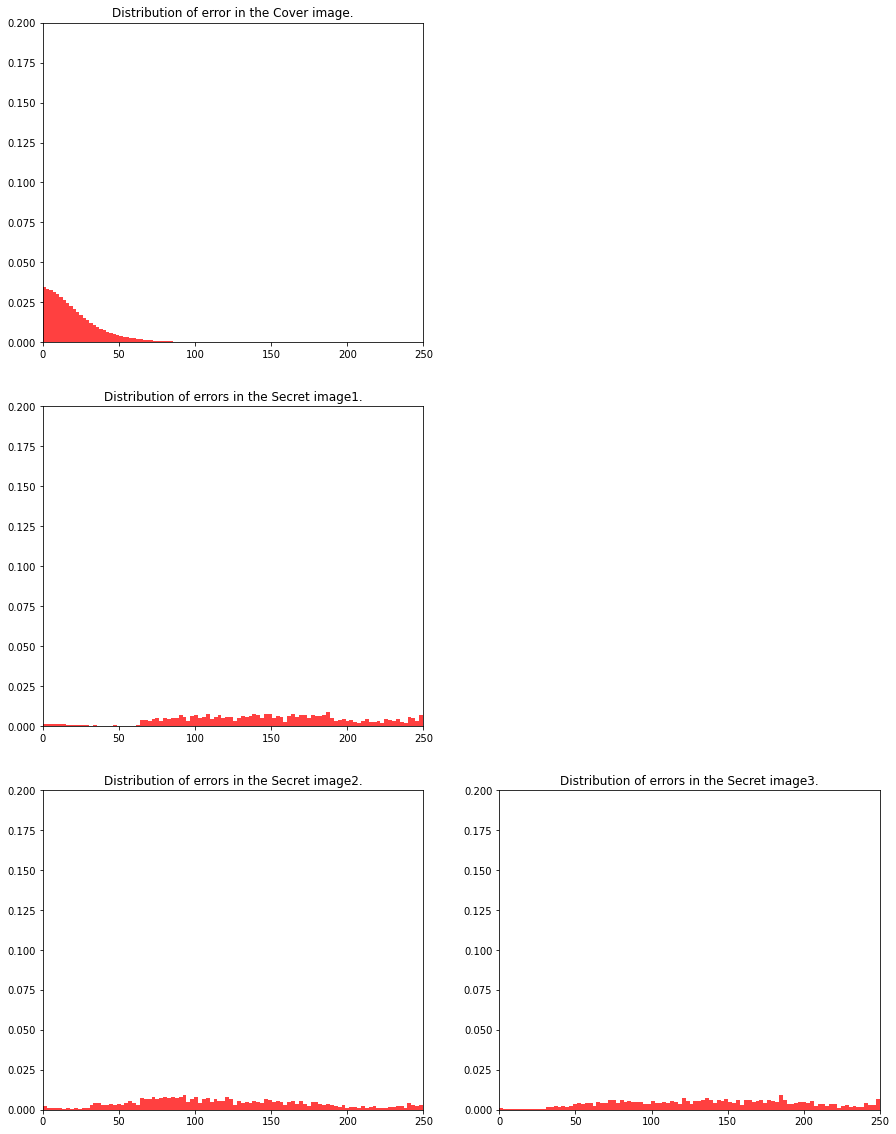

In [ ]:
# diff_S1 = np.abs(input_sec1 - input_S1)
# diff_S2 = np.abs(input_sec2 - input_S2)
# diff_S3 = np.abs(input_sec3- input_S3)

#print(diff_S1, diff_S2, diff_S3)
#input_C=np.expand_dims(input_C, axis=-1)
#decoded_C.resize((263,64,64,3))
#input_C=np.resize(input_C,(262,64,64,3))

out_diff_C = np.abs(decoded_C - input_C)

#print(decoded_C.shape,input_C.shape)
# Get absolute difference between the outputs and the expected values.
# diff_S1, diff_S2, diff_S3, diff_C = np.abs(input_sec1 - input_S1), np.abs(input_sec2 - input_S2), np.abs(input_sec3 - input_S3), np.abs(input_C - input_C) 

def pixel_histogram(diff_S1, diff_S2, diff_S3, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_S1flat = diff_S1.flatten()
    #print(diff_S1flat)
    diff_S2flat = diff_S2.flatten()
    diff_S3flat = diff_S3.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 20))
    a=fig.add_subplot(3,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, density = True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(3,2,3)
    imgplot = plt.hist(diff_S1flat, 100, density = True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image1.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(3,2,5)
    imgplot = plt.hist(diff_S2flat, 100, density = True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image2.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(3,2,6)
    imgplot = plt.hist(diff_S3flat, 100, density = True, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image3.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()
pixel_histogram(out_diff_S1, out_diff_S2, out_diff_S3, out_diff_C)

# see_S1pixel = np.sqrt(np.mean(np.square(((out_diff_S1))))
# see_S2pixel = np.sqrt(np.mean(np.square((out_diff_S2)/255)))
# see_S3pixel = np.sqrt(np.mean(np.square((out_diff_S3)/255)))
# print(see_S1pixel)
# print(see_S2pixel)
# print(see_S3pixel)